In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [39]:
df = pd.read_csv('../dataset/GOOG-year.csv')
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [40]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias=0.1,
    ):
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.size = size
        self.size_layer = size_layer
        self.output_size = output_size
        self.forget_bias = forget_bias

        self.build_model()

    def build_model(self):
        
        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [self.lstm_cell() for _ in range(self.num_layers)],
            state_is_tuple=False,
        )
        tf.compat.v1.disable_eager_execution()
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, self.size), name="input_X")
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, self.output_size), name="output_Y")
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = self.forget_bias
        )

        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, self.num_layers * 2 * self.size_layer), name="hidden_layer"
        )

        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop,
            self.X,
            initial_state=self.hidden_layer,
            dtype=tf.float32,
        )

        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
        self.calculate_loss_and_optimize()

    def lstm_cell(self):
        return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)

    def calculate_loss_and_optimize(self):
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits), name="cost")
        self.optimizer = tf.compat.v1.train.AdamOptimizer(self.learning_rate).minimize(
            self.cost, name="optimizer"
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100



In [41]:


def train_model(model, sess, df_train, timestamp, epoch):
    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, model.num_layers * 2 * model.size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
            batch_y = df_train.iloc[k + 1:index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [model.logits, model.last_state, model.optimizer, model.cost],
                feed_dict={
                    model.X: batch_x,
                    model.Y: batch_y,
                    model.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

def generate_predictions(model, sess, df_train, timestamp, future_day, test_size):
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, model.num_layers * 2 * model.size_layer))

    for k in range(0, upper_b, timestamp):
        out_logits, last_state = sess.run(
            [model.logits, model.last_state],
            feed_dict={
                model.X: np.expand_dims(df_train.iloc[k:k + timestamp], axis=0),
                model.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1:k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [model.logits, model.last_state],
            feed_dict={
                model.X: np.expand_dims(df_train.iloc[upper_b:], axis=0),
                model.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1:df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [model.logits, model.last_state],
            feed_dict={
                model.X: np.expand_dims(o, axis=0),
                model.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]

    return output_predict[-test_size:]

def forecast():
    tf.compat.v1.reset_default_graph()
    model = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df_train.iloc[:, 0]).tolist()

    train_model(model, sess, df_train, timestamp, epoch)

    future_day = test_size
    output_predictions = generate_predictions(model, sess, df_train, timestamp, future_day, test_size)

    date_ori.extend([date_ori[-1] + timedelta(days=i) for i in range(1, test_size + 1)])

    output_predictions = minmax.inverse_transform(output_predictions)
    buffer = []
    last = output_predictions[:, 0][0]
    for i in output_predictions[:, 0]:
        smoothed_val = last * 0.3 + (1 - 0.3) * i
        buffer.append(smoothed_val)
        last = smoothed_val 
    return buffer[-test_size:]


In [42]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train lo

simulation 2



C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:20<00:00, 14.78it/s, acc=96.9, cost=0.00261]

simulation 3



C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:20<00:00, 14.90it/s, acc=96.8, cost=0.00281]


simulation 4


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train lo

simulation 5



C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:20<00:00, 14.87it/s, acc=97.1, cost=0.00217]


simulation 6


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train lo

simulation 7


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train lo

simulation 8



C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:19<00:00, 15.02it/s, acc=97, cost=0.00249]  

simulation 9



C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:20<00:00, 14.92it/s, acc=97.2, cost=0.00214]


simulation 10


C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:48: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(self.size_layer, state_is_tuple=False)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11848\535390505.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(self.outputs[-1], self.output_size, name="logits")
d:\Anaconda\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train lo

max number: 9.0000
max accuracy: 95.7728
average accuracy: 94.8147


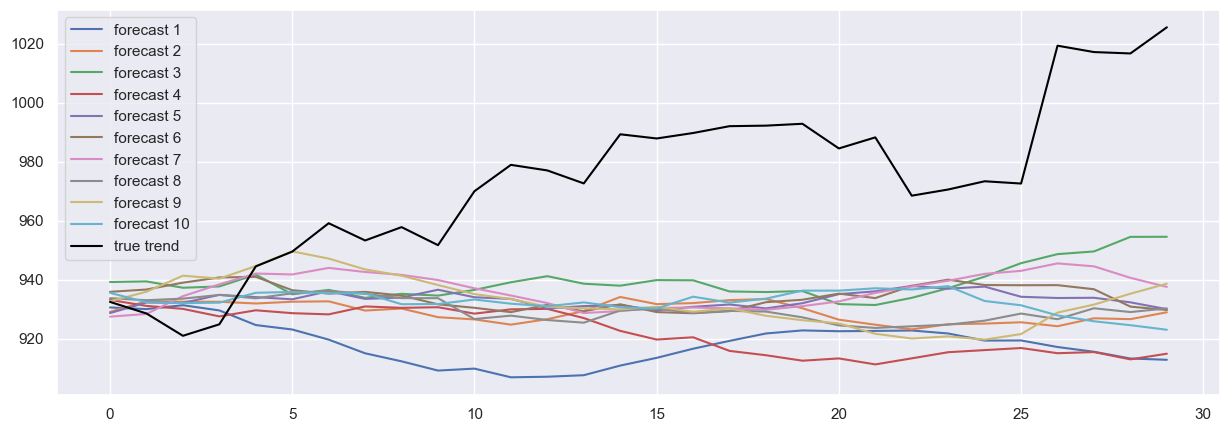

In [43]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]
plt.figure(figsize = (15, 5))
count = 0
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
print('max number: %.4f'%(i))
print('max accuracy: %.4f'%(np.max(accuracies)))
print('average accuracy: %.4f'%(np.mean(accuracies)))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.show()